In [90]:
import numpy as np
import scipy.io.wavfile
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


mic_0: (60000,) samples, 22050 Hz


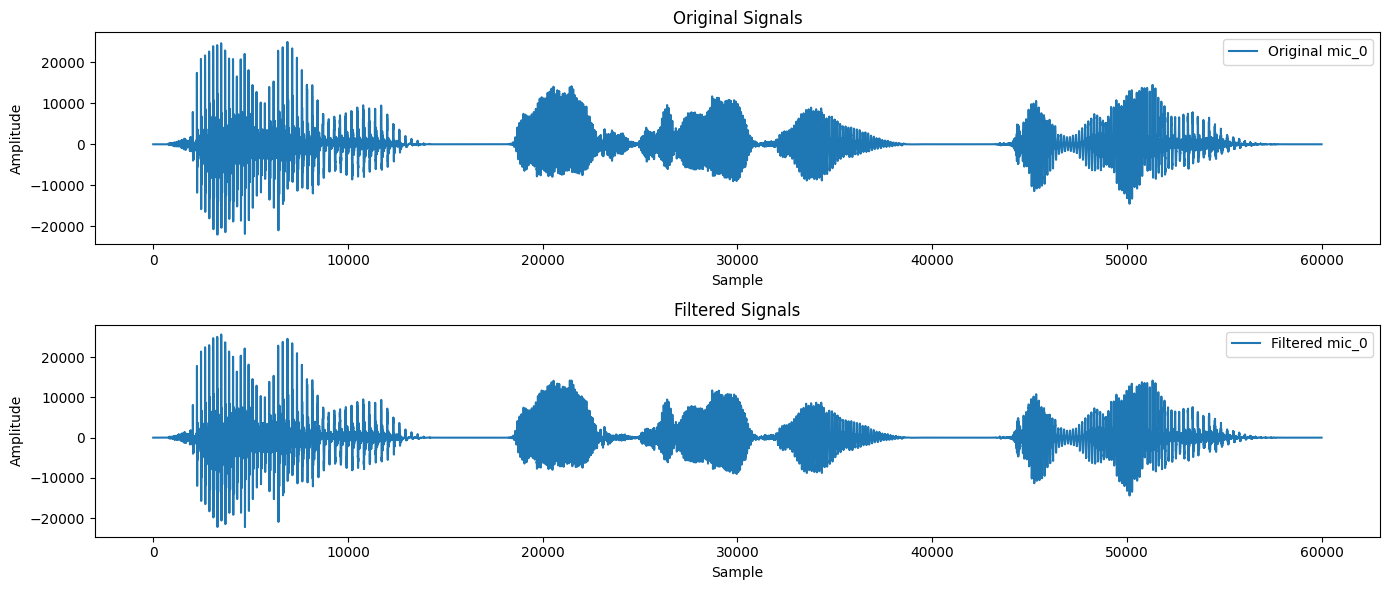

In [91]:
n_clusters = 3
# --- Step 1: Load Audio Files ---

mic_data_folder = "dataset" + str(n_clusters)
sr_0, mic_0 = scipy.io.wavfile.read(f"{mic_data_folder}/0.wav")
sr_1, mic_1 = scipy.io.wavfile.read(f"{mic_data_folder}/1.wav")
print(f"mic_0: {mic_0.shape} samples, {sr_0} Hz")
sr = sr_0



# high pass filter
def high_pass_filter(signal, cutoff_freq, sr, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff_freq / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    return scipy.signal.lfilter(b, a, signal)
# --- Step 3: Create Low Pass Filter ---
def low_pass_filter(signal, cutoff_freq, sr, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff_freq / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    return scipy.signal.lfilter(b, a, signal)
    # BEGIN: Filter out noise
def filter_noise(signal, threshold):
        return np.where(np.abs(signal) > threshold, signal, 0)

cutoff_freq = 4000  # Cutoff frequency in Hz

# Apply the high pass filter, reducing the dc component
mic_0 = high_pass_filter(mic_0, 20, sr)
mic_1 = high_pass_filter(mic_1, 20, sr)
# Apply the low pass filter
mic_0_filtered = low_pass_filter(mic_0, cutoff_freq, sr)
mic_1_filtered = low_pass_filter(mic_1, cutoff_freq, sr)



# Plot the original signals
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(mic_0, label='Original mic_0')
#plt.plot(mic_1, label='Original mic_1')
plt.title('Original Signals')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()



# Plot the filtered signals
plt.subplot(2, 1, 2)
#plt.plot(mic_0_filtered, label='Filtered mic_0')
plt.plot(mic_0_filtered, label='Filtered mic_0')
plt.title('Filtered Signals')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

# Update the mic_0 and mic_1 variables with the filtered signals
mic_0 = mic_0_filtered
mic_1 = mic_1_filtered

In [92]:
# --- Step 2: Calculate STFT ---
n_fft = 2048  # Window size
hop_length = n_fft // 4  # Hop size
window = 'hann'  # Window type

F, T, stft_0 = scipy.signal.stft(mic_0, sr, window=window, nperseg=n_fft, noverlap=n_fft - hop_length)
F, T, stft_1 = scipy.signal.stft(mic_1, sr, window=window, nperseg=n_fft, noverlap=n_fft - hop_length)

In [93]:
# Find the threshold of the top 10% magnitude of stft_0
log_magnitude_stft_0 = np.log(np.abs(stft_0) + 1e-10)
log_magnitude_stft_1 = np.log(np.abs(stft_1) + 1e-10)
threshold = np.percentile(log_magnitude_stft_0, 95)
print(f"Threshold for top 10% magnitude of stft_0: {threshold}")

Threshold for top 10% magnitude of stft_0: 3.7974134338234578


distance between microphones:  0.03718921757074787
N clusters:  3


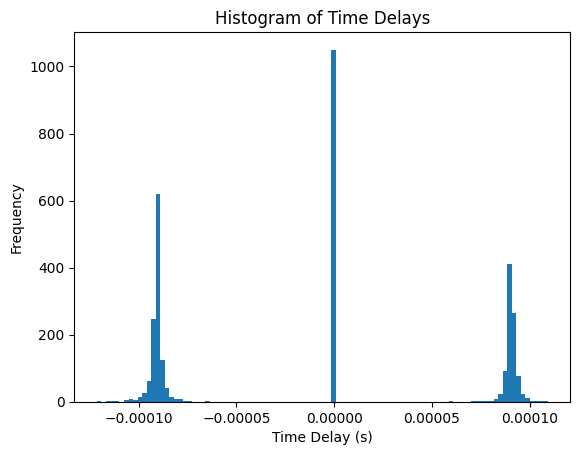

In [94]:
delta_t = []
i=0
k = 0
time_var = []
original_signals = []
delay_times = []
for i in range(0,F.shape[0]):
    for j in range(0,T.shape[0]):
        
        frequency = F[i]
        time = T[j]
        
        phase_diff = np.angle(stft_0[i,j]) - np.angle(stft_1[i,j])
        dt = phase_diff / (2 * np.pi * frequency+1e-10)
        delay_times.append(dt)
        if(frequency>1000 or frequency<20): # remove aliasing
            continue
        if(np.log(np.abs(stft_0[i,j])) < threshold):
            continue
        if(abs(dt)>0.2/340):
            continue
        delta_t.append(dt)
print("distance between microphones: ", np.max(delta_t)*340)
delta_t = np.array(delta_t)
delay_times = np.array(delay_times)
print("N clusters: ", n_clusters)
# Plot histogram of delta_t
plt.hist(delta_t, bins=100)
plt.title('Histogram of Time Delays')
plt.xlabel('Time Delay (s)')
plt.ylabel('Frequency')
#plt.xlim(-10*1e-4,10*1e-4)
plt.show()



In [95]:
# Cluster the delta_t values
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(delta_t.reshape(-1, 1))
print("Cluster centers:", kmeans.cluster_centers_)

# using the cluster centers to predict the masks for the delay times
masks = kmeans.predict(delay_times.reshape(-1, 1))
masks = masks.reshape(stft_0.shape)
print(masks.shape)

Cluster centers: [[ 9.07784976e-05]
 [-9.09288541e-05]
 [-9.09263939e-10]]
(1025, 119)


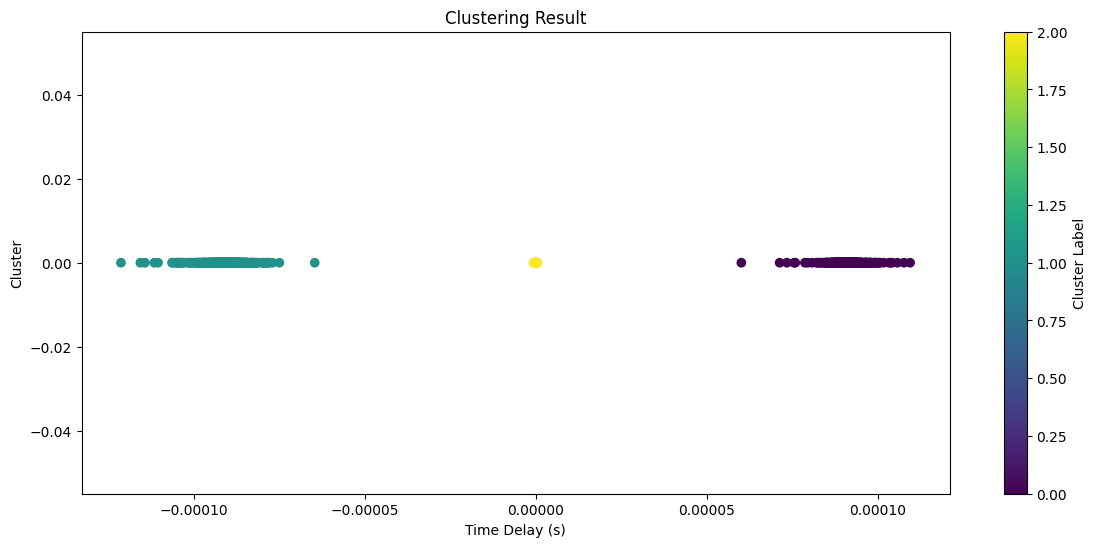

In [96]:
# Plot the clustering result
plt.figure(figsize=(14, 6))
plt.scatter(delta_t, np.zeros_like(delta_t), c=labels, cmap='viridis', marker='o')
plt.title('Clustering Result')
plt.xlabel('Time Delay (s)')
plt.ylabel('Cluster')
plt.colorbar(label='Cluster Label')
plt.show()

In [97]:
sources = []
for k in range(n_clusters):
    # Apply mask to S_R1 to isolate bins for source k
    S_source_k = stft_0 * (masks==k)
    # Reconstruct the time-domain signal
    source_k = scipy.signal.istft(S_source_k, sr, window=window, nperseg=n_fft, noverlap=n_fft - hop_length)[1]
    sources.append(source_k)
    scipy.io.wavfile.write(f"{k}.wav", sr, source_k.astype(np.int16))

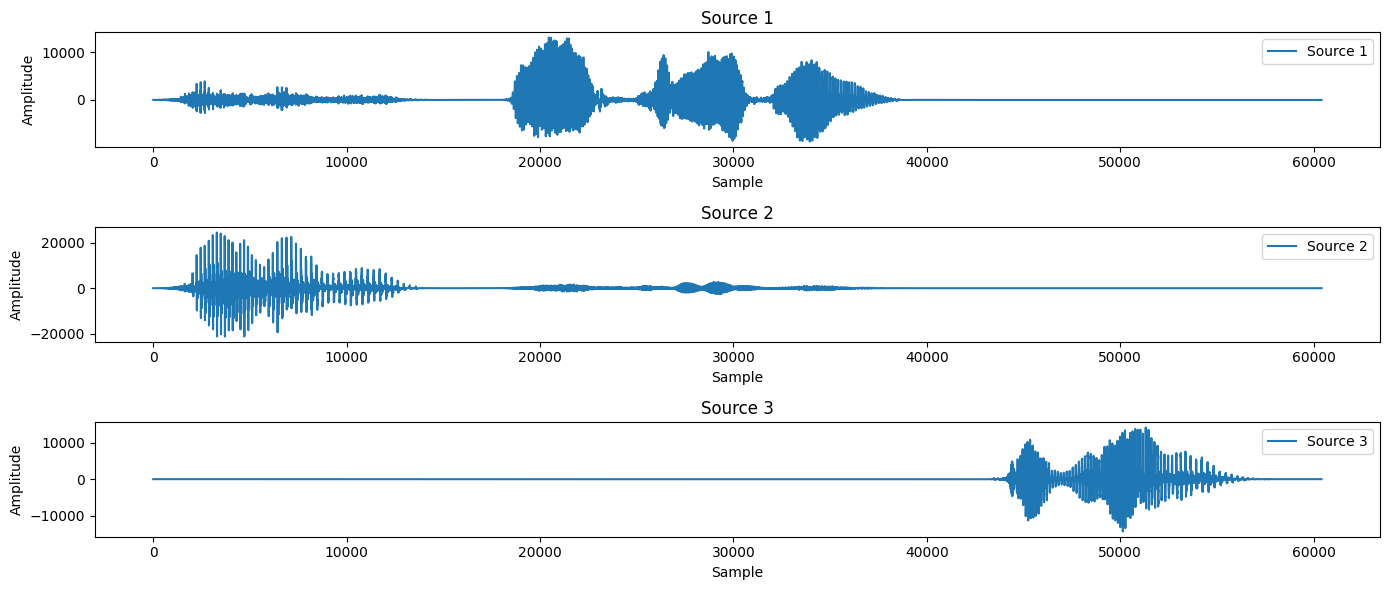

In [98]:
# Plot the sources
plt.figure(figsize=(14, 6))
for idx, source in enumerate(sources):
    plt.subplot(len(sources), 1, idx + 1)
    plt.plot(source, label=f'Source {idx + 1}')
    plt.title(f'Source {idx + 1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()